In [60]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## load movie data

In [61]:
org_data = pd.read_csv('/content/sample_data/movies_dataset.csv')

## 数据摘要
### 标称数据： appropriate_for, director, industry, language, storyline, title, id and writer
### 其中有意义的： appropriate_for, director, industry, language and writer
### storyline, title, id 三者几乎是unique 但数据存在问题,存在部分重复样本
### 数值数据： imdb_rating, downloads, posted_date, release_date, run_time, views
### 都具有一定意义

In [62]:
nominals = ['appropriate_for', 'director',  'industry', 'language', 'writer']
numerics = ['imdb_rating', 'downloads', 'posted_date', 'release_date', 'run_time', 'views']
# drop first col
data = org_data.drop(columns='Unnamed: 0')
# Convert column names into snake_case.
data.columns = data.columns.str.replace('-', '_').str.lower()

# Make views and dowloads numeric.
for col in 'downloads', 'views':
    data[col] = data[col].str.replace(',','')
    data[col] = data[col].astype('float')
# Make id strings.
data['id'] = data['id'].astype('str')
# Output formte
pd.options.display.float_format = '{:.2f}'.format
def run_time_process(e):
    e = str(e).replace(' ', '')
    if e == 'nan':
        return np.nan
    if 'h' not in e and 'min' not in e:
        return int(e)
    else:
        hour = 0
        minute = 0
        if 'h' in e:
            hour = int(e.split('h')[0])
        if 'min' in e:
            minute = int(e.split('min')[0].split('h')[-1])
        return int(hour * 60 + minute)
## Run time process
# Convert '1h20min' format to minutes
data['run_time'] = data['run_time'].apply(run_time_process)
# Convert '102' format to minutes
data['run_time'] = pd.to_numeric(data['run_time'], errors='coerce').fillna(np.nan)
# Make dates datetime.
data['old_posted_date'] = data['posted_date']
data['posted_date'] = pd.to_datetime(data['posted_date'])

data['old_release_date'] = data['release_date']
data['release_date'] = pd.to_datetime(data['release_date'])

In [63]:
data

,imdb_rating,appropriate_for,director,downloads,id,industry,language,posted_date,release_date,run_time,storyline,title,views,writer,old_posted_date,old_release_date
0,4.80,R,John Swab,304.00,372092,Hollywood / English,English,2023-02-20,2023-01-28,105.00,Doc\r\n facilitates a fragile truce between th...,Little Dixie,2794.00,John Swab,"20 Feb, 2023",Jan 28 2023
1,6.40,TV-PG,Paul Ziller,73.00,372091,Hollywood / English,English,2023-02-20,2023-02-05,84.00,Caterer\r\n Goldy Berry reunites with detectiv...,Grilling Season: A Curious Caterer Mystery,1002.00,John Christian Plummer,"20 Feb, 2023",Feb 05 2023
2,5.20,R,Ben Wheatley,1427.00,343381,Hollywood / English,"English,Hindi",2021-04-20,2021-06-18,107.00,As the world searches for a cure to a disastro...,In the Earth,14419.00,Ben Wheatley,"20 Apr, 2021",Jun 18 2021
3,8.10,NaN,Venky Atluri,1549.00,372090,Tollywood,Hindi,2023-02-20,2023-02-17,139.00,The life of a young man and his struggles agai...,Vaathi,4878.00,Venky Atluri,"20 Feb, 2023",Feb 17 2023
4,4.60,NaN,Shaji Kailas,657.00,372089,Tollywood,Hindi,2023-02-20,2023-01-26,122.00,A man named Kalidas gets stranded due to the p...,Alone,2438.00,Rajesh Jayaraman,"20 Feb, 2023",Jan 26 2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20543,NaN,NaN,NaN,1998.00,28957,Bollywood / Indian,Hindi,1970-01-01,1959-03-13,NaN,NaN,Bhai-Bahen,6219.00,NaN,"01 Jan, 1970",Mar 13 1959
20544,7.70,NaN,Bimal Roy,6080.00,28958,Bollywood / Indian,Hindi,1970-01-01,1955-05-13,159.00,Devdas and Parvati had been inseparable as chi...,Devdas,16376.00,"Rajinder Singh Bedi, Saratchandra Chatterjee, ...","01 Jan, 1970",May 13 1955
20545,8.00,NaN,NaN,3276.00,30459,Bollywood / Indian,Hindi,1970-01-01,1958-03-28,110.00,"While driving his car on a rainy night, Anand'...",Madhumati,7220.00,NaN,"01 Jan, 1970",Mar 28 1958
20546,NaN,NaN,NaN,309.00,371669,Wrestling,English,2023-02-10,2023-02-09,NaN,NaN,TNA.Impact 2023-02-09,1419.00,NaN,"10 Feb, 2023",Feb 09 2023


## 标称属性
### 标称属性的缺失值的个数

Text(0.5, 1.0, 'num of nan values')

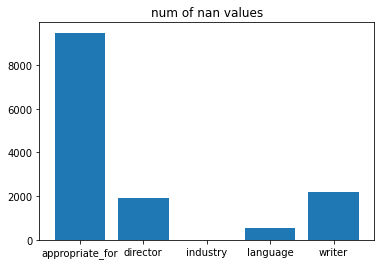

In [64]:
ax = nominals
ay = []
for attr in nominals:
    freq = 5
    ay.append(data[attr].isna().sum())
plt.bar(ax, ay)
plt.title('num of nan values')

### 标称属性的每个可能取值的频数
#### 通过.value_counts()取得，这里仅展示频度前五的结果

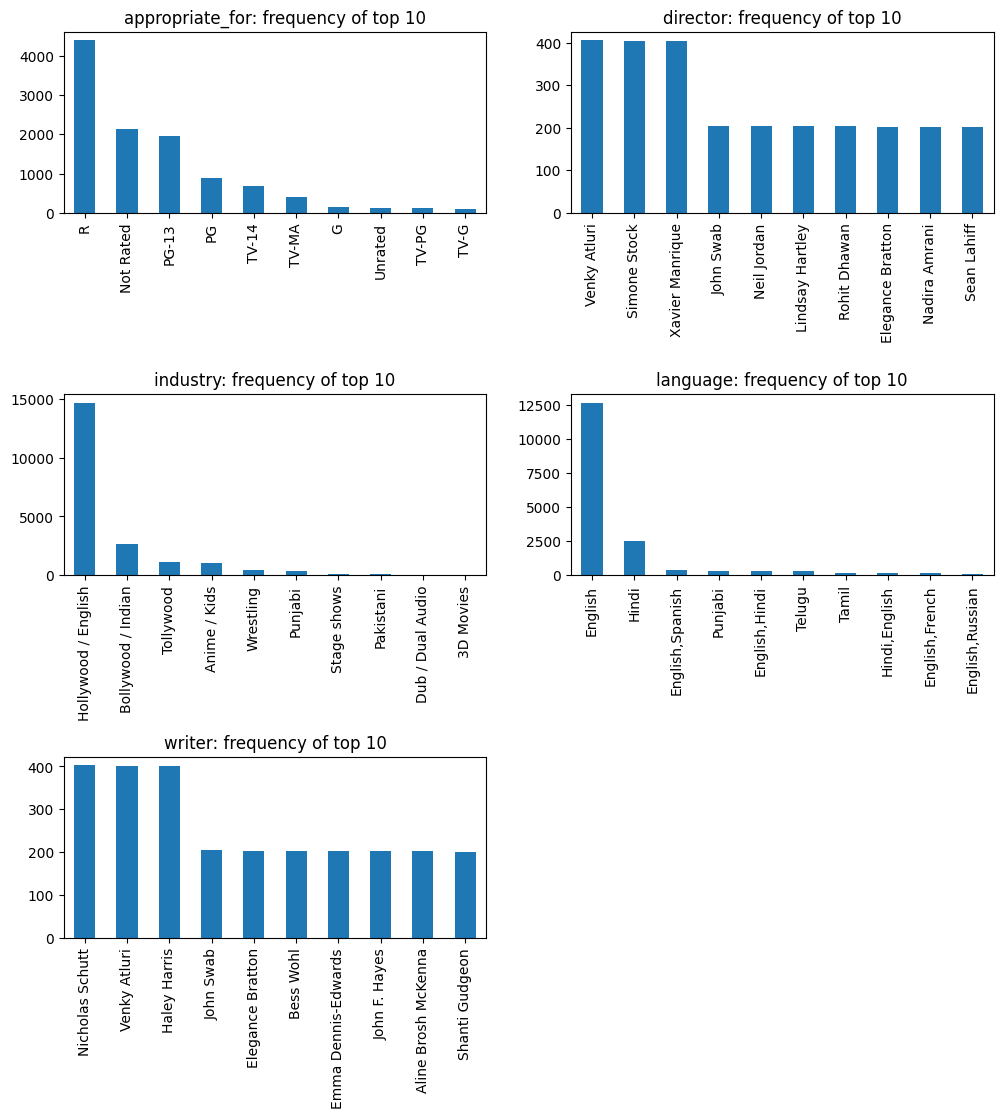

In [65]:
index = 1
plt.figure(figsize=(12,12), dpi=100).subplots_adjust(hspace=1)
plt.figure(1)
col = 2
row = int(len(nominals) / col) + 1
for attr in nominals:
    plt.subplot(row, col, index)
    index += 1
    freq = 10
    data[attr].value_counts().head(freq).plot.bar()
    plt.title(f'{attr}: frequency of top {freq}')

## 数值属性
### 数值属性的缺失值个数

Text(0.5, 1.0, 'Num of nan values')

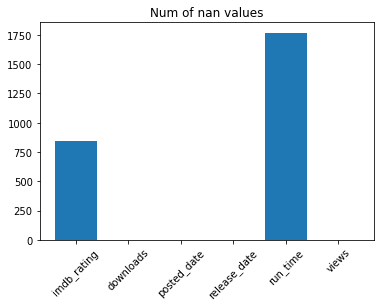

In [66]:
ax = range(len(numerics))
ay = []
for attr in numerics:
    freq = 5
    ay.append(data[attr].isna().sum())
plt.bar(ax, ay)
plt.xticks(ax, numerics, rotation=45)
plt.title('Num of nan values')

## 数值属性的五数、盒图 
### release date
####     处理时 仅关注年份信息

count   20547.00
mean     2013.70
std        12.77
min      1921.00
25%      2013.00
50%      2017.00
75%      2021.00
max      2023.00
Name: release_date, dtype: float64


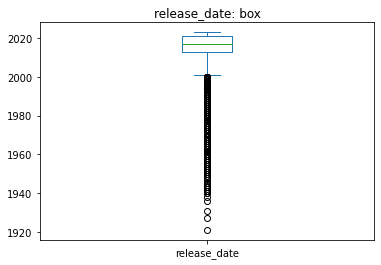

In [67]:
attr = 'release_date'
print(data[attr].dt.year.describe())
visit = pd.DataFrame(data[attr].dt.year)
visit.plot.box()
plt.title(attr + ': box')
plt.show()

### posted date
####     处理时仅关注年份信息

count   20547.00
mean     2017.00
std         6.10
min      1970.00
25%      2014.00
50%      2018.00
75%      2022.00
max      2023.00
Name: posted_date, dtype: float64


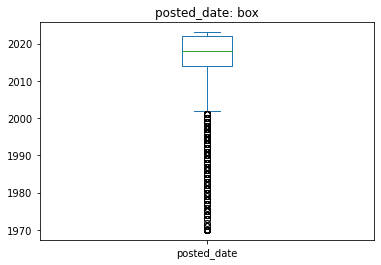

In [68]:
attr = 'posted_date'
print(data[attr].dt.year.describe())
visit = pd.DataFrame(data[attr].dt.year)
visit.plot.box()
plt.title(attr + ': box')
plt.show()

### imdb rating

count   19707.00
mean        5.76
std         1.37
min         1.10
25%         4.80
50%         5.70
75%         6.60
max         9.90
Name: imdb_rating, dtype: float64


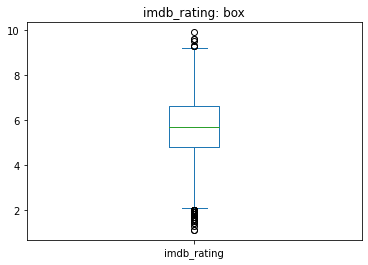

In [69]:
attr = 'imdb_rating'
print(data[attr].describe())
visit = pd.DataFrame(data[attr])
visit.plot.box()
plt.title(attr + ': box')
plt.show()

### downloads

count    20547.00
mean     10795.24
std      23716.18
min          0.00
25%        855.50
50%       2716.00
75%      10070.00
max     391272.00
Name: downloads, dtype: float64


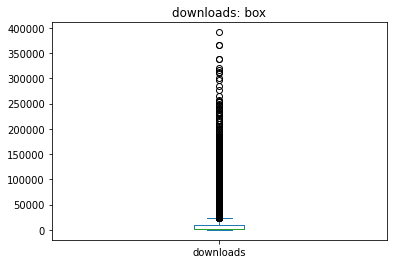

In [70]:
attr = 'downloads'
print(data[attr].describe())
visit = pd.DataFrame(data[attr])
visit.plot.box()
plt.title(attr + ': box')
plt.show()

### run_time
#### 单位为分钟

count   18780.00
mean      106.20
std        23.64
min         2.00
25%        90.00
50%       100.00
75%       117.00
max       321.00
Name: run_time, dtype: float64


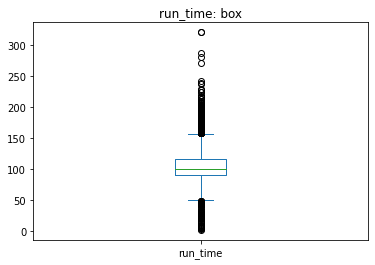

In [71]:
attr = 'run_time'
print(data[attr].describe())
visit = pd.DataFrame(data[attr])
visit.plot.box()
plt.title(attr + ': box')
plt.show()

### views

count     20547.00
mean      35595.51
std       62472.42
min         667.00
25%        7571.50
50%       15222.00
75%       36571.00
max     1638533.00
Name: views, dtype: float64


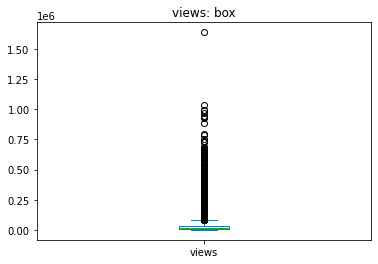

In [72]:
attr = 'views'
print(data[attr].describe())
visit = pd.DataFrame(data[attr])
visit.plot.box()
plt.title(attr + ': box')
plt.show()

## 缺失值处理
### 剔除
#### 剔除后仅剩9902条数据，远少于原数据量20548

In [73]:
new_data = data.dropna()

In [74]:
new_data

,imdb_rating,appropriate_for,director,downloads,id,industry,language,posted_date,release_date,run_time,storyline,title,views,writer,old_posted_date,old_release_date
0,4.80,R,John Swab,304.00,372092,Hollywood / English,English,2023-02-20,2023-01-28,105.00,Doc\r\n facilitates a fragile truce between th...,Little Dixie,2794.00,John Swab,"20 Feb, 2023",Jan 28 2023
1,6.40,TV-PG,Paul Ziller,73.00,372091,Hollywood / English,English,2023-02-20,2023-02-05,84.00,Caterer\r\n Goldy Berry reunites with detectiv...,Grilling Season: A Curious Caterer Mystery,1002.00,John Christian Plummer,"20 Feb, 2023",Feb 05 2023
2,5.20,R,Ben Wheatley,1427.00,343381,Hollywood / English,"English,Hindi",2021-04-20,2021-06-18,107.00,As the world searches for a cure to a disastro...,In the Earth,14419.00,Ben Wheatley,"20 Apr, 2021",Jun 18 2021
7,6.50,R,Benjamin Caron,1781.00,371751,Hollywood / English,English,2023-02-13,2023-02-17,116.00,"Motivations are suspect, and expectations are ...",Sharper,18225.00,"Brian Gatewood, Alessandro Tanaka","13 Feb, 2023",Feb 17 2023
8,6.90,PG-13,Ravi Kapoor,458.00,372042,Hollywood / English,English,2023-02-18,2022-12-02,80.00,An\r\n unmotivated South Asian American rapper...,Four Samosas,6912.00,Ravi Kapoor,"18 Feb, 2023",Dec 02 2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20522,7.10,Not Rated,Biren Nag,1932.00,23825,Bollywood / Indian,Hindi,1970-01-01,1962-05-11,158.00,"After a lusty Thakur rapes a young girl, she k...",Bees Saal Baad,6076.00,"Dhruva Chatterjee, Dev Kishan","01 Jan, 1970",May 11 1962
20525,7.00,G,Guy Hamilton,2544.00,25548,Hollywood / English,"English,German,Polish,French",1970-01-01,1969-09-17,132.00,Historical reenactment of the air war in the e...,Battle of Britain,9319.00,"James Kennaway, Wilfred Greatorex, Derek Dempster","01 Jan, 1970",Sep 17 1969
20533,5.60,R,Barbara Topsøe-Rothenborg,12284.00,1173,Hollywood / English,"Spanish,German,English",2016-05-26,1970-01-01,90.00,"LOVE AT FIRST HICCUP is a charming, innocent, ...",Love at First Hiccup,36022.00,"Barbara Topsøe-Rothenborg, Søren Frellesen, De...","26 May, 2016",Jan 01 1970
20537,7.10,Not Rated,Biren Nag,1932.00,23825,Bollywood / Indian,Hindi,1970-01-01,1962-05-11,158.00,"After a lusty Thakur rapes a young girl, she k...",Bees Saal Baad,6077.00,"Dhruva Chatterjee, Dev Kishan","01 Jan, 1970",May 11 1962


#### 标称属性变化

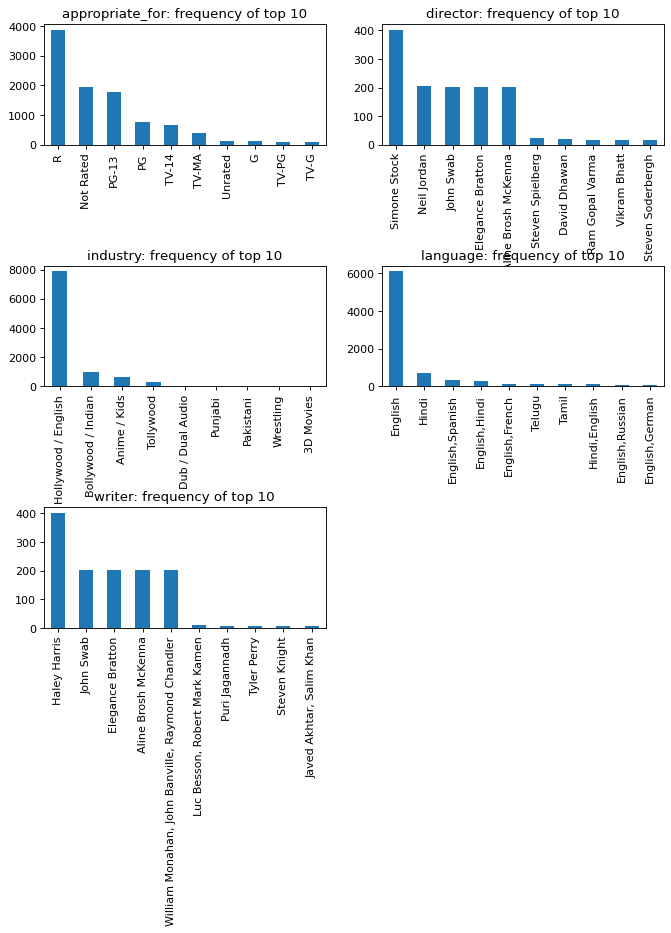

In [75]:
index = 1
plt.figure(figsize=(10,10), dpi=80).subplots_adjust(hspace=1)
plt.figure(1)
col = 2
row = int(len(nominals) / col) + 1
for attr in nominals:
    plt.subplot(row, col, index)
    index += 1
    freq = 10
    new_data[attr].value_counts().head(freq).plot.bar()
    plt.title(attr + ': frequency of top {}'.format(freq))

#### 数值属性变化

release_date
count   9902.00
mean    2013.67
std       10.98
min     1931.00
25%     2012.00
50%     2016.00
75%     2020.00
max     2023.00
Name: release_date, dtype: float64


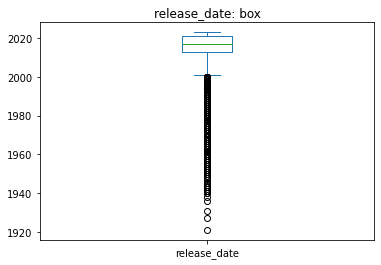

posted_date
count   9902.00
mean    2016.27
std        5.87
min     1970.00
25%     2013.00
50%     2017.00
75%     2021.00
max     2023.00
Name: posted_date, dtype: float64


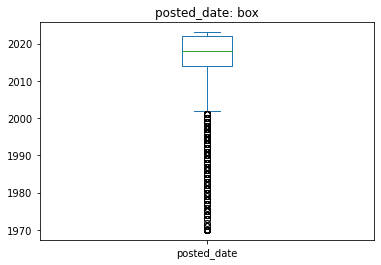

imdb_rating
count   9902.00
mean       5.88
std        1.20
min        1.10
25%        5.20
50%        6.00
75%        6.67
max        9.30
Name: imdb_rating, dtype: float64


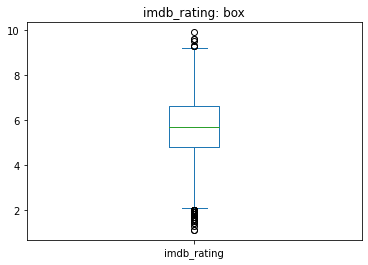

downloads
count     9902.00
mean     16154.57
std      31018.63
min          0.00
25%       1340.25
50%       4473.00
75%      16538.50
max     391272.00
Name: downloads, dtype: float64


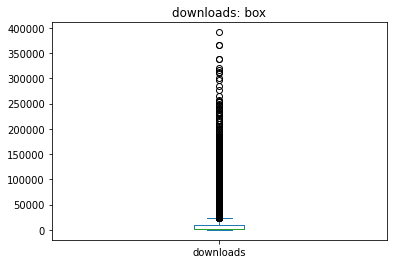

run_time
count   9902.00
mean     106.91
std       22.73
min       21.00
25%       91.00
50%      101.00
75%      116.00
max      321.00
Name: run_time, dtype: float64


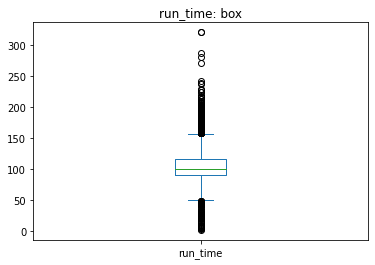

views
count      9902.00
mean      49980.30
std       81018.37
min        1002.00
25%       10234.50
50%       22258.00
75%       54012.25
max     1638533.00
Name: views, dtype: float64


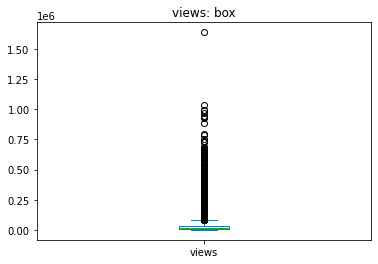

In [76]:
attrs = ['release_date', 'posted_date', 'imdb_rating', 'downloads', 'run_time', 'views']
for attr in attrs:
  print(attr)
  try:
    print(new_data[attr].dt.year.describe())
    visit = pd.DataFrame(data[attr].dt.year)
  except:
    print(new_data[attr].describe())
    visit = pd.DataFrame(data[attr])
  
  visit.plot.box()
  plt.title(attr + ': box')
  # plt.show()

### 最高频率值填补

In [77]:
attrs = nominals + numerics
new_data = data.copy(deep=True)
for attr in attrs:
    most = data[attr].value_counts().index[0]
    new_data[attr] = data[attr].fillna(most)
new_data

,imdb_rating,appropriate_for,director,downloads,id,industry,language,posted_date,release_date,run_time,storyline,title,views,writer,old_posted_date,old_release_date
0,4.80,R,John Swab,304.00,372092,Hollywood / English,English,2023-02-20,2023-01-28,105.00,Doc\r\n facilitates a fragile truce between th...,Little Dixie,2794.00,John Swab,"20 Feb, 2023",Jan 28 2023
1,6.40,TV-PG,Paul Ziller,73.00,372091,Hollywood / English,English,2023-02-20,2023-02-05,84.00,Caterer\r\n Goldy Berry reunites with detectiv...,Grilling Season: A Curious Caterer Mystery,1002.00,John Christian Plummer,"20 Feb, 2023",Feb 05 2023
2,5.20,R,Ben Wheatley,1427.00,343381,Hollywood / English,"English,Hindi",2021-04-20,2021-06-18,107.00,As the world searches for a cure to a disastro...,In the Earth,14419.00,Ben Wheatley,"20 Apr, 2021",Jun 18 2021
3,8.10,R,Venky Atluri,1549.00,372090,Tollywood,Hindi,2023-02-20,2023-02-17,139.00,The life of a young man and his struggles agai...,Vaathi,4878.00,Venky Atluri,"20 Feb, 2023",Feb 17 2023
4,4.60,R,Shaji Kailas,657.00,372089,Tollywood,Hindi,2023-02-20,2023-01-26,122.00,A man named Kalidas gets stranded due to the p...,Alone,2438.00,Rajesh Jayaraman,"20 Feb, 2023",Jan 26 2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20543,6.60,R,Venky Atluri,1998.00,28957,Bollywood / Indian,Hindi,1970-01-01,1959-03-13,90.00,NaN,Bhai-Bahen,6219.00,Nicholas Schutt,"01 Jan, 1970",Mar 13 1959
20544,7.70,R,Bimal Roy,6080.00,28958,Bollywood / Indian,Hindi,1970-01-01,1955-05-13,159.00,Devdas and Parvati had been inseparable as chi...,Devdas,16376.00,"Rajinder Singh Bedi, Saratchandra Chatterjee, ...","01 Jan, 1970",May 13 1955
20545,8.00,R,Venky Atluri,3276.00,30459,Bollywood / Indian,Hindi,1970-01-01,1958-03-28,110.00,"While driving his car on a rainy night, Anand'...",Madhumati,7220.00,Nicholas Schutt,"01 Jan, 1970",Mar 28 1958
20546,6.60,R,Venky Atluri,309.00,371669,Wrestling,English,2023-02-10,2023-02-09,90.00,NaN,TNA.Impact 2023-02-09,1419.00,Nicholas Schutt,"10 Feb, 2023",Feb 09 2023


#### 标称属性变化

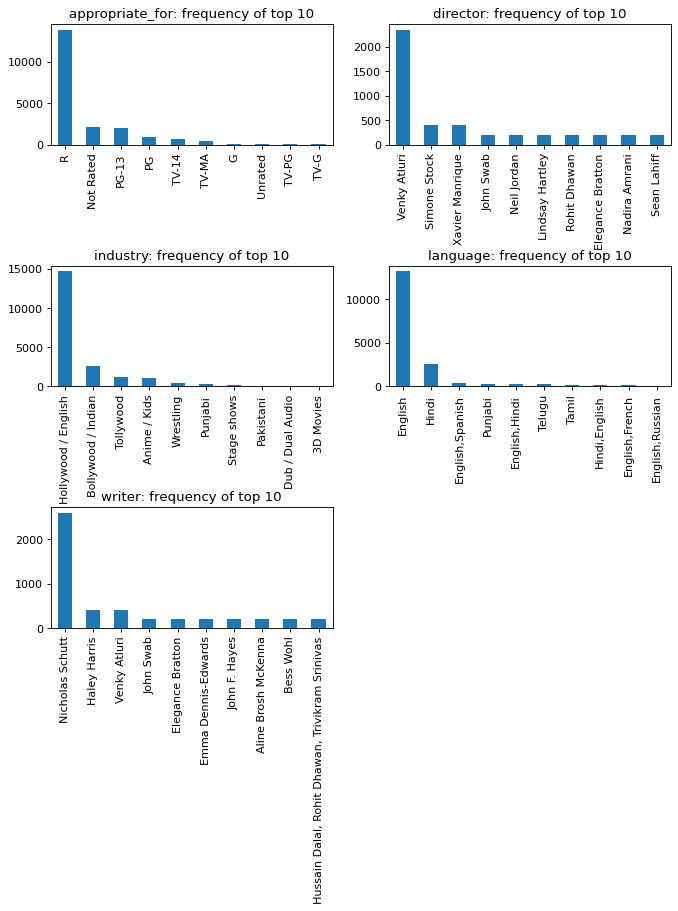

In [78]:
index = 1
plt.figure(figsize=(10,10), dpi=80).subplots_adjust(hspace=1)
plt.figure(1)
col = 2
row = int(len(nominals) / col) + 1
for attr in nominals:
    plt.subplot(row, col, index)
    index += 1
    freq = 10
    new_data[attr].value_counts().head(freq).plot.bar()
    plt.title(f'{attr}: frequency of top {freq}')

#### 数值属性变化

release_date
count   20548.00
mean     2013.69
std        12.77
min      1921.00
25%      2013.00
50%      2017.00
75%      2021.00
max      2023.00
Name: release_date, dtype: float64


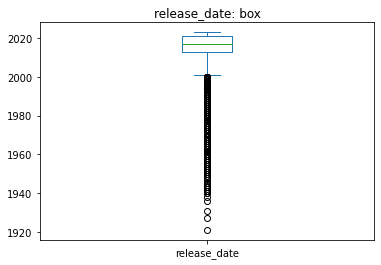

posted_date
count   20548.00
mean     2017.00
std         6.10
min      1970.00
25%      2014.00
50%      2018.00
75%      2022.00
max      2023.00
Name: posted_date, dtype: float64


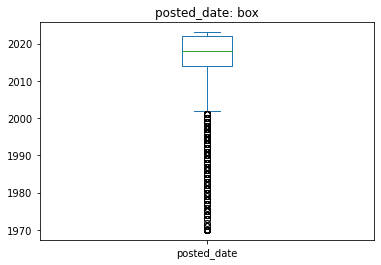

imdb_rating
count   20548.00
mean        5.80
std         1.36
min         1.10
25%         4.90
50%         5.80
75%         6.60
max         9.90
Name: imdb_rating, dtype: float64


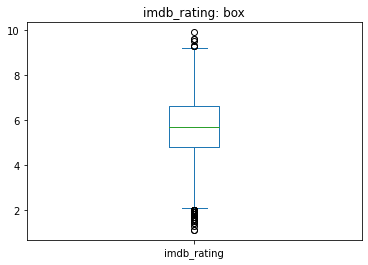

downloads
count    20548.00
mean     10794.72
std      23715.72
min          0.00
25%        854.75
50%       2716.00
75%      10069.50
max     391272.00
Name: downloads, dtype: float64


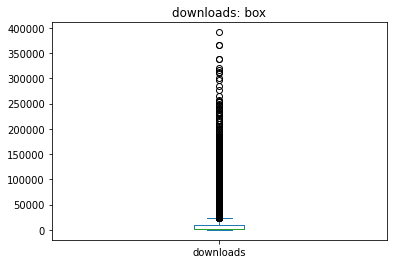

run_time
count   20548.00
mean      104.80
std        23.05
min         2.00
25%        90.00
50%        98.00
75%       114.00
max       321.00
Name: run_time, dtype: float64


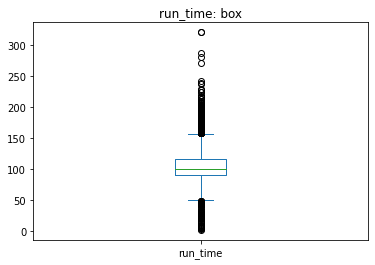

views
count     20548.00
mean      35594.08
std       62471.24
min         667.00
25%        7571.00
50%       15221.50
75%       36569.50
max     1638533.00
Name: views, dtype: float64


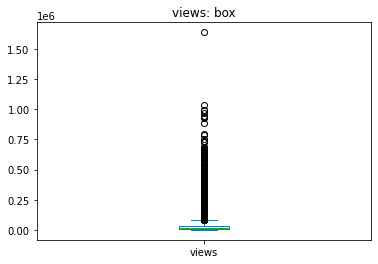

In [79]:
attrs = ['release_date', 'posted_date', 'imdb_rating', 'downloads', 'run_time', 'views']
for attr in attrs:
  print(attr)
  try:
    print(new_data[attr].dt.year.describe())
    visit = pd.DataFrame(data[attr].dt.year)
  except:
    print(new_data[attr].describe())
    visit = pd.DataFrame(data[attr])
  
  visit.plot.box()
  plt.title(attr + ': box')
  # plt.show()

### 相关关系填补

In [80]:
new_data = data.copy(deep=True)
corr_matrix = new_data.corr()
corr_matrix

,imdb_rating,downloads,run_time,views
imdb_rating,1.00,0.08,0.33,0.07
downloads,0.08,1.00,0.35,0.95
run_time,0.33,0.35,1.00,0.33
views,0.07,0.95,0.33,1.00


#### 虽然downloads与view呈现高相关性 但数据集中缺失downloads的数据也同时缺失views(仅一条 index 149)
#### 此外imdb_rating的缺失都伴随着run_time download的缺失 同时views数据与其不存在明显的关系 因此无法利用此方法填补缺失值
#### 对于run_time数据缺失使用downloads预测
#### 使用随机森林算法

In [81]:
from sklearn.ensemble import RandomForestRegressor
data_map = new_data[['run_time', 'downloads']].dropna()
rfr_1 = RandomForestRegressor(random_state=0, n_estimators=200,  n_jobs=-1)
matrix = data_map.values
X = matrix[:, 0].reshape(-1,1)
y = matrix[:, 1]
rfr_1.fit(X, y)
data_map = new_data[['run_time', 'downloads']].dropna(subset=['downloads'])
X = data_map[data_map.run_time.isnull()].values[:, 1].reshape(-1, 1)
prediction = rfr_1.predict(X)
new_data.loc[(new_data['run_time'].isna() & new_data['downloads'].notna()), 'run_time'] = prediction

new_data

,imdb_rating,appropriate_for,director,downloads,id,industry,language,posted_date,release_date,run_time,storyline,title,views,writer,old_posted_date,old_release_date
0,4.80,R,John Swab,304.00,372092,Hollywood / English,English,2023-02-20,2023-01-28,105.00,Doc\r\n facilitates a fragile truce between th...,Little Dixie,2794.00,John Swab,"20 Feb, 2023",Jan 28 2023
1,6.40,TV-PG,Paul Ziller,73.00,372091,Hollywood / English,English,2023-02-20,2023-02-05,84.00,Caterer\r\n Goldy Berry reunites with detectiv...,Grilling Season: A Curious Caterer Mystery,1002.00,John Christian Plummer,"20 Feb, 2023",Feb 05 2023
2,5.20,R,Ben Wheatley,1427.00,343381,Hollywood / English,"English,Hindi",2021-04-20,2021-06-18,107.00,As the world searches for a cure to a disastro...,In the Earth,14419.00,Ben Wheatley,"20 Apr, 2021",Jun 18 2021
3,8.10,NaN,Venky Atluri,1549.00,372090,Tollywood,Hindi,2023-02-20,2023-02-17,139.00,The life of a young man and his struggles agai...,Vaathi,4878.00,Venky Atluri,"20 Feb, 2023",Feb 17 2023
4,4.60,NaN,Shaji Kailas,657.00,372089,Tollywood,Hindi,2023-02-20,2023-01-26,122.00,A man named Kalidas gets stranded due to the p...,Alone,2438.00,Rajesh Jayaraman,"20 Feb, 2023",Jan 26 2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20543,NaN,NaN,NaN,1998.00,28957,Bollywood / Indian,Hindi,1970-01-01,1959-03-13,119596.30,NaN,Bhai-Bahen,6219.00,NaN,"01 Jan, 1970",Mar 13 1959
20544,7.70,NaN,Bimal Roy,6080.00,28958,Bollywood / Indian,Hindi,1970-01-01,1955-05-13,159.00,Devdas and Parvati had been inseparable as chi...,Devdas,16376.00,"Rajinder Singh Bedi, Saratchandra Chatterjee, ...","01 Jan, 1970",May 13 1955
20545,8.00,NaN,NaN,3276.00,30459,Bollywood / Indian,Hindi,1970-01-01,1958-03-28,110.00,"While driving his car on a rainy night, Anand'...",Madhumati,7220.00,NaN,"01 Jan, 1970",Mar 28 1958
20546,NaN,NaN,NaN,309.00,371669,Wrestling,English,2023-02-10,2023-02-09,119596.30,NaN,TNA.Impact 2023-02-09,1419.00,NaN,"10 Feb, 2023",Feb 09 2023


#### 标称属性变化

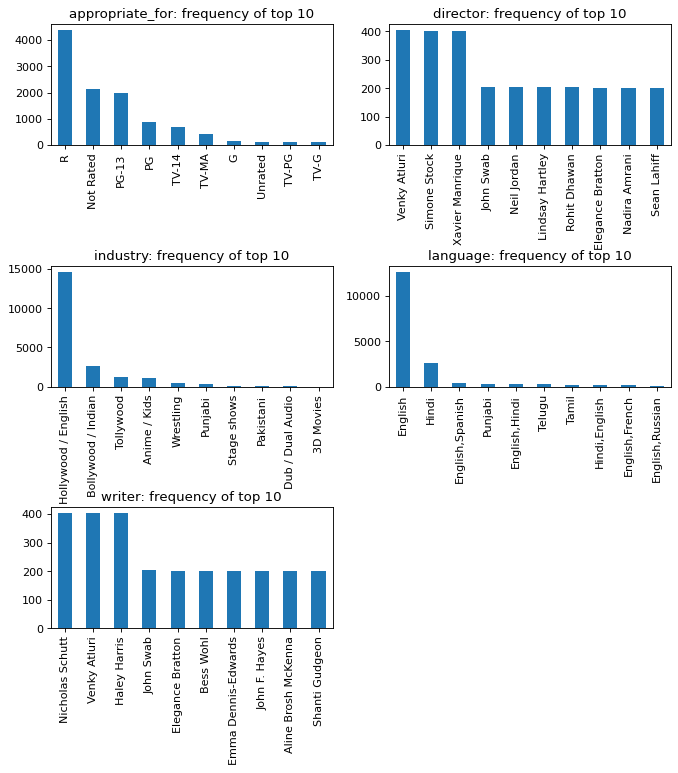

In [82]:
index = 1
plt.figure(figsize=(10,10), dpi=80).subplots_adjust(hspace=1)
plt.figure(1)
col = 2
row = int(len(nominals) / col) + 1
for attr in nominals:
    plt.subplot(row, col, index)
    index += 1
    freq = 10
    new_data[attr].value_counts().head(freq).plot.bar()
    plt.title(f'{attr}: frequency of top {freq}')

#### 数值属性变化

release_date
count   20547.00
mean     2013.70
std        12.77
min      1921.00
25%      2013.00
50%      2017.00
75%      2021.00
max      2023.00
Name: release_date, dtype: float64
posted_date
count   20547.00
mean     2017.00
std         6.10
min      1970.00
25%      2014.00
50%      2018.00
75%      2022.00
max      2023.00
Name: posted_date, dtype: float64
imdb_rating
count   20548.00
mean        5.76
std         1.35
min         1.10
25%         4.90
50%         5.76
75%         6.60
max         9.90
Name: imdb_rating, dtype: float64
downloads
count    20548.00
mean     10795.23
std      23715.60
min          0.00
25%        855.75
50%       2716.00
75%      10073.25
max     391272.00
Name: downloads, dtype: float64
run_time
count   20548.00
mean      106.14
std        22.92
min         2.00
25%        90.00
50%       101.00
75%       116.00
max       321.00
Name: run_time, dtype: float64
views
count     20548.00
mean      35595.51
std       62470.90
min         667.00
25%     

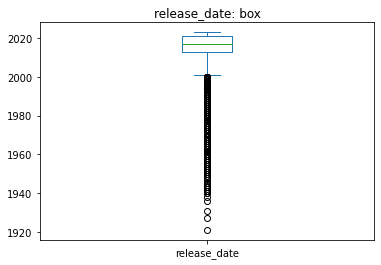

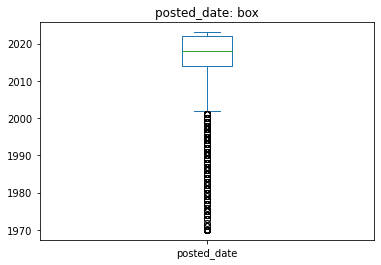

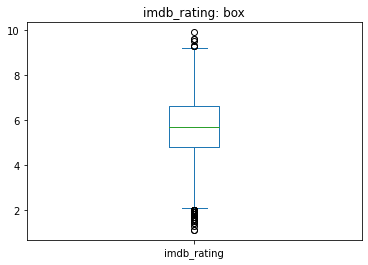

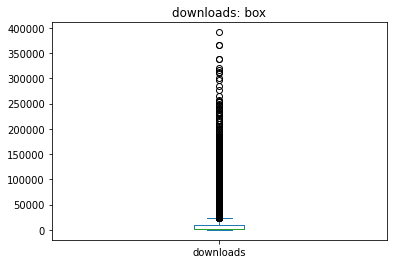

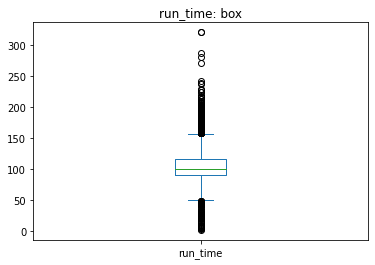

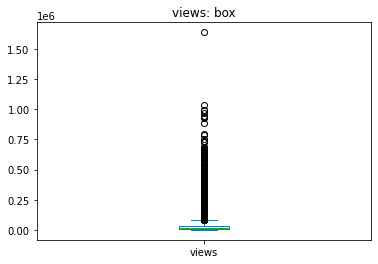

In [89]:
attrs = ['release_date', 'posted_date', 'imdb_rating', 'downloads', 'run_time', 'views']
for attr in attrs:
  print(attr)
  try:
    print(new_data[attr].dt.year.describe())
    visit = pd.DataFrame(data[attr].dt.year)
  except:
    print(new_data[attr].describe())
    visit = pd.DataFrame(data[attr])
  
  visit.plot.box()
  plt.title(attr + ': box')
  # plt.show()

### 基于相似性 
#### 利用impyute工具 对几个数值属性进行填补

In [84]:
# pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
from impyute import fast_knn
features = ['imdb_rating', 'views', 'downloads', 'run_time']
new_data = data.copy(True)
new_data[features] = pd.DataFrame(fast_knn(np.array(new_data[features]), k=2), columns=features)
new_data.isnull().any()

imdb_rating         False
appropriate_for      True
director             True
downloads           False
id                  False
industry             True
language             True
posted_date          True
release_date         True
run_time            False
storyline            True
title                True
views               False
writer               True
old_posted_date      True
old_release_date     True
dtype: bool

#### 标称属性变化

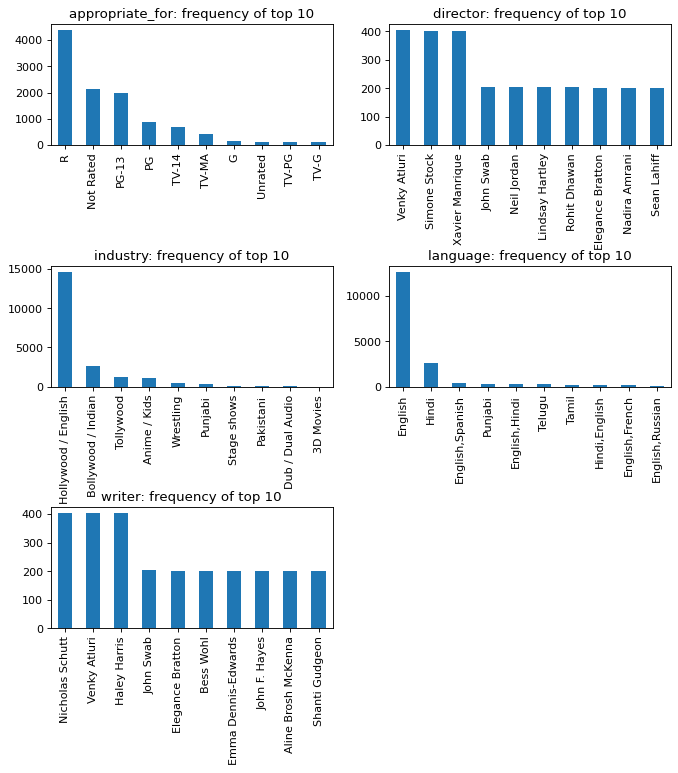

In [86]:
index = 1
plt.figure(figsize=(10,10), dpi=80).subplots_adjust(hspace=1)
plt.figure(1)
col = 2
row = int(len(nominals) / col) + 1
for attr in nominals:
    plt.subplot(row, col, index)
    index += 1
    freq = 10
    new_data[attr].value_counts().head(freq).plot.bar()
    plt.title(f'{attr}: frequency of top {freq}')

#### 数值属性变化

release_date
count   20547.00
mean     2013.70
std        12.77
min      1921.00
25%      2013.00
50%      2017.00
75%      2021.00
max      2023.00
Name: release_date, dtype: float64
posted_date
count   20547.00
mean     2017.00
std         6.10
min      1970.00
25%      2014.00
50%      2018.00
75%      2022.00
max      2023.00
Name: posted_date, dtype: float64
imdb_rating
count   20548.00
mean        5.76
std         1.35
min         1.10
25%         4.90
50%         5.76
75%         6.60
max         9.90
Name: imdb_rating, dtype: float64
downloads
count    20548.00
mean     10795.23
std      23715.60
min          0.00
25%        855.75
50%       2716.00
75%      10073.25
max     391272.00
Name: downloads, dtype: float64
run_time
count   20548.00
mean      106.14
std        22.92
min         2.00
25%        90.00
50%       101.00
75%       116.00
max       321.00
Name: run_time, dtype: float64
views
count     20548.00
mean      35595.51
std       62470.90
min         667.00
25%     

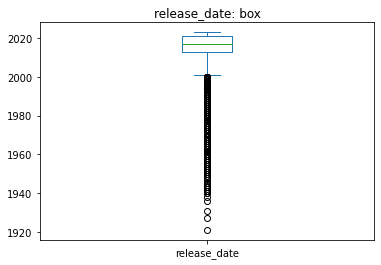

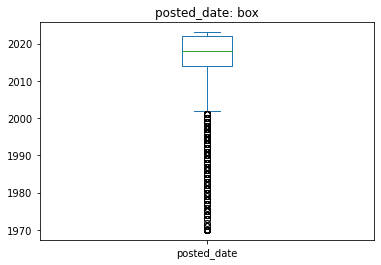

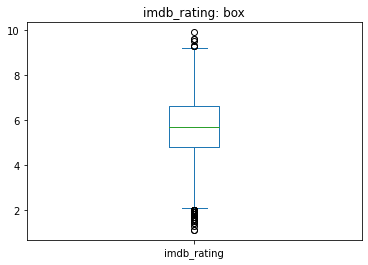

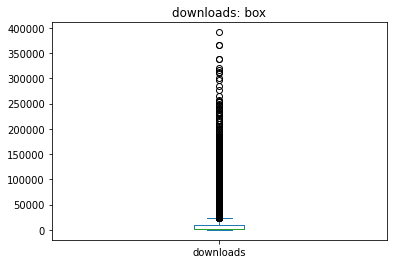

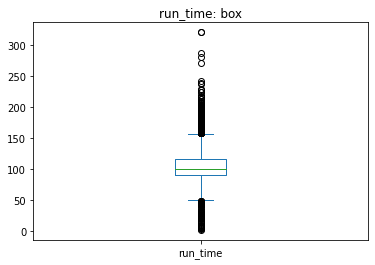

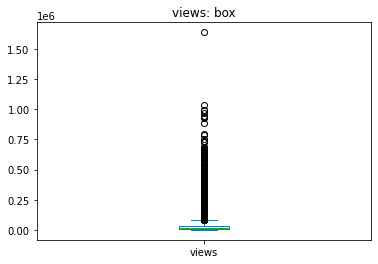

In [88]:
attrs = ['release_date', 'posted_date', 'imdb_rating', 'downloads', 'run_time', 'views']
for attr in attrs:
  print(attr)
  try:
    print(new_data[attr].dt.year.describe())
    visit = pd.DataFrame(data[attr].dt.year)
  except:
    print(new_data[attr].describe())
    visit = pd.DataFrame(data[attr])
  
  visit.plot.box()
  plt.title(attr + ': box')
  # plt.show()